# 1. Install Dependencies and Setup

In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
%pip list

Package                       Version
----------------------------- --------------
absl-py                       2.1.0
accelerate                    0.33.0
aiohttp                       3.9.5
aiosignal                     1.3.1
altair                        5.2.0
anyio                         4.4.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asgiref                       3.7.2
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
attrs                         23.2.0
Babel                         2.15.0
beautifulsoup4                4.12.2
bleach                        6.1.0
blinker                       1.7.0
Brotli                        1.1.0
cachetools                    5.3.3
certifi                       2024.2.2
cffi                          1.16.0
charset-normalizer            3.3.2
click                         8.1.7
colorama                      0.4.6
comm   

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\Admin\AppData\Local\Temp\ipykernel_23028\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

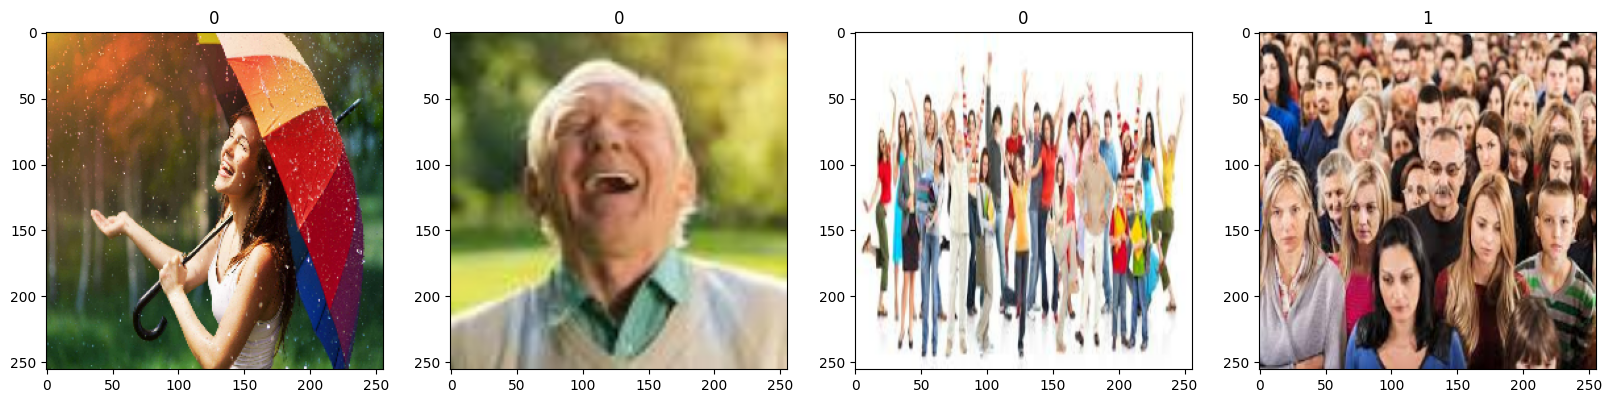

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.94516695, 0.94516695, 0.94516695],
          [0.9490196 , 0.9490196 , 0.9490196 ],
          [0.9493643 , 0.9493643 , 0.9493643 ],
          ...,
          [0.11950061, 0.12342218, 0.09204964],
          [0.14385723, 0.1477788 , 0.11640625],
          [0.13354014, 0.1374617 , 0.10608915]],
 
         [[0.94516695, 0.94516695, 0.94516695],
          [0.9490196 , 0.9490196 , 0.9490196 ],
          [0.9493643 , 0.9493643 , 0.9493643 ],
          ...,
          [0.119712  , 0.12363356, 0.09226101],
          [0.14385723, 0.1477788 , 0.11640625],
          [0.13826564, 0.14218721, 0.11081465]],
 
         [[0.9465364 , 0.9465364 , 0.9465364 ],
          [0.9490931 , 0.9490931 , 0.9490931 ],
          [0.9507583 , 0.9507583 , 0.9507583 ],
          ...,
          [0.11984528, 0.12376685, 0.09518229],
          [0.14385723, 0.1477788 , 0.11919424],
          [0.14398439, 0.14790596, 0.1193214 ]],
 
         ...,
 
         [[0.45265013, 0.45265013, 0.45265013],
          [0.98493

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 980ms/step - accuracy: 0.4654 - loss: 1.3276 - val_accuracy: 0.4688 - val_loss: 0.6975
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.5310 - loss: 0.6675 - val_accuracy: 0.8438 - val_loss: 0.6179
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step - accuracy: 0.7171 - loss: 0.6324 - val_accuracy: 0.5781 - val_loss: 0.6006
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step - accuracy: 0.7129 - loss: 0.5653 - val_accuracy: 0.9375 - val_loss: 0.5025
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 717ms/step - accuracy: 0.8322 - loss: 0.4911 - val_accuracy: 0.9375 - val_loss: 0.2877
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - accuracy: 0.8667 - loss: 0.3989 - val_accuracy: 0.9375 - val_loss: 0.2707
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8988 - loss: 0.2759 - val_accuracy: 0.9219 - val_loss: 0.2779
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9498 - loss: 0.1948 - val_accuracy: 0.9688 - val_loss: 0.

# 8. Plot Performance

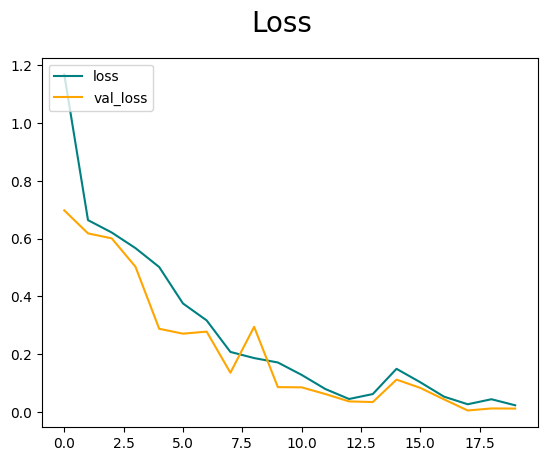

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

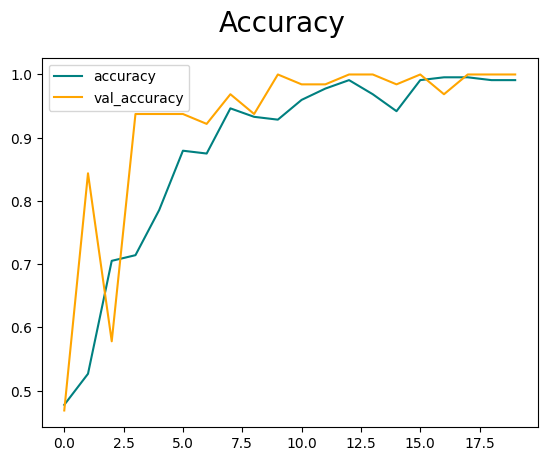

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

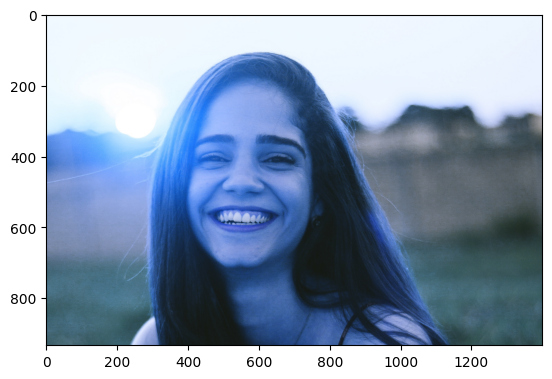

In [36]:
img = cv2.imread('happy2.png')
plt.imshow(img)
plt.show()

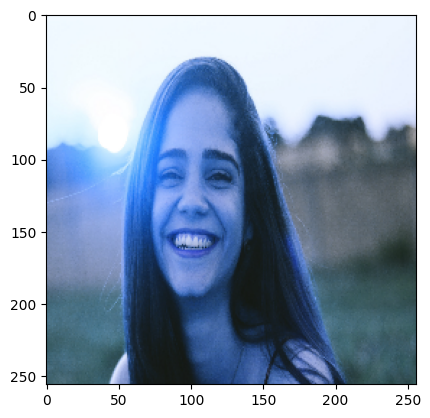

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [39]:
yhat

array([[0.3029562]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model('models/imageclassifier.h5')

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([[0.3029562]], dtype=float32)